In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [2]:
pnl = 0
DATA_DIR       = './data'
SYMBOLS_CSV    = 'symbols.csv'
WINDOW_SIZE    = 183
WIDE_SIZE      = 303
VOLUME_THRESHOLD = 100_000
NOTIONAL       = 100.0

In [3]:
def prepare_data():
    symbols = pd.read_csv(SYMBOLS_CSV)['symbol'].iloc[:-4].tolist()
    data_dict = {}
    for sym in symbols:
        df = pd.read_csv(os.path.join(DATA_DIR, f'{sym}.csv'))
        df['open_time'] = pd.to_datetime(df['open_time'])
        df[['open','high','low','close','volume']] = df[['open','high','low','close','volume']].apply(pd.to_numeric, errors='coerce')
        df.sort_values('open_time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        df['time_index'] = (df['open_time'] - df['open_time'].iloc[0]).dt.total_seconds()
        data_dict[sym] = df
    return data_dict

In [4]:
def create_model(df):
    X = sm.add_constant(df['time_index'])
    y = df['close']
    return sm.OLS(y, X).fit()

In [5]:
def get_predictions(df, model, alpha=0.01):
    X_new = sm.add_constant(df['time_index'])
    return model.get_prediction(X_new).summary_frame(alpha=alpha)

In [6]:
def get_slope(df, pred_summary):
    x0, xN = df['time_index'].iloc[0], df['time_index'].iloc[-1]
    y0, yN = pred_summary['mean'].iloc[0], pred_summary['mean'].iloc[-1]
    pct_change = (yN - y0) / y0 * 100
    minutes = (xN - x0) / 60
    return pct_change / minutes if minutes > 0 else 0

In [7]:
def get_lower_series(lower_series, horizon=WIDE_SIZE):
    n = len(lower_series)
    slope = (lower_series.iloc[-1] - lower_series.iloc[0]) / (n - 1)
    intercept = lower_series.iloc[0]
    x = np.arange(horizon)
    return pd.Series(intercept + slope * x)

In [8]:
def draw(window, lower_preds, ticker, sell_time, sell_price,buy_time,buy_price):
    df = window.copy()
    last_price = df['close'].iloc[-1]
    last_time = df['open_time'].iloc[-1]
    last_lower = lower_preds.iloc[-1]

    plt.figure(figsize=(14, 6))
    plt.plot(df['open_time'], df['close'], label='Real Price',color='black',linewidth=1)
    plt.plot(df['open_time'], lower_preds.iloc[:len(df)], '--', label='Lower CI Projection')
    plt.axvline(x=df['open_time'].iloc[183], color='red', linestyle='--', label='Knowledge Base')
    plt.scatter([sell_time], [sell_price], color='red', label='Signal Price')
    plt.scatter([buy_time], [buy_price], color='green', label='Signal Price')
    
    plt.text(last_time, last_price, f' Last Price: {last_price:.6f}', color='orange', fontsize=10)
    plt.text(last_time, last_lower, f' ↓ {last_lower:.6f}', color='red', fontsize=10)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'Sell Signal - {ticker}')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


took profit @104791.600000   pnl: 0.05


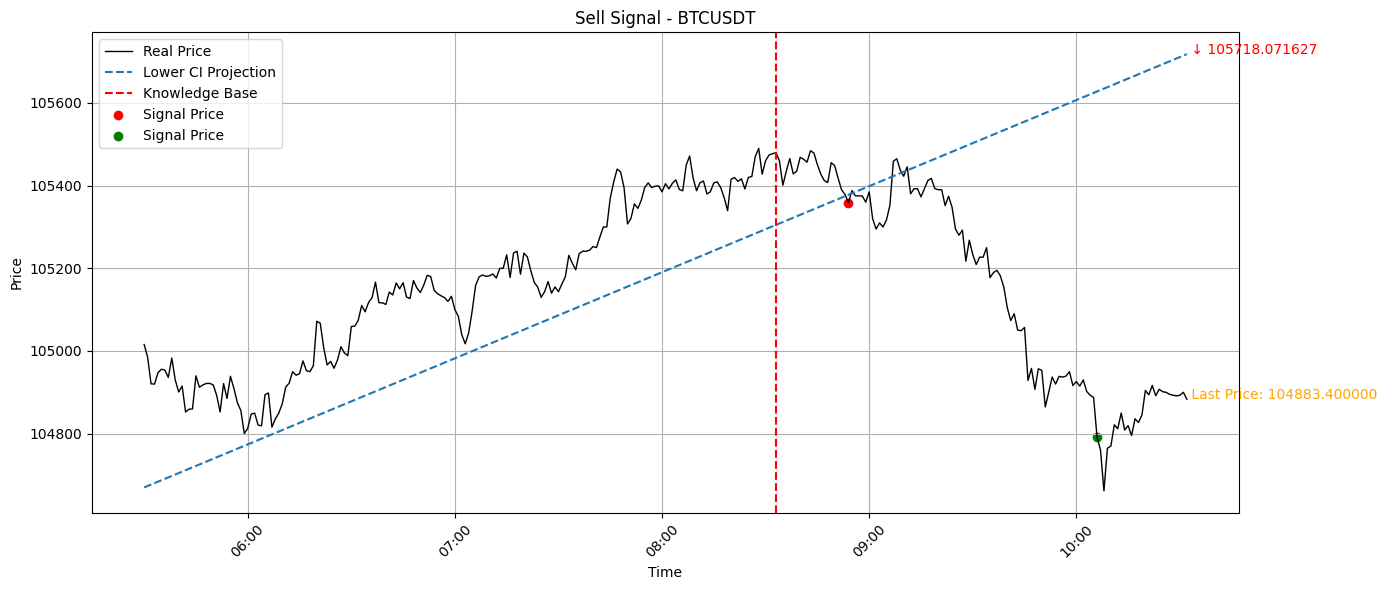

took profit @16.731000   pnl: 0.1


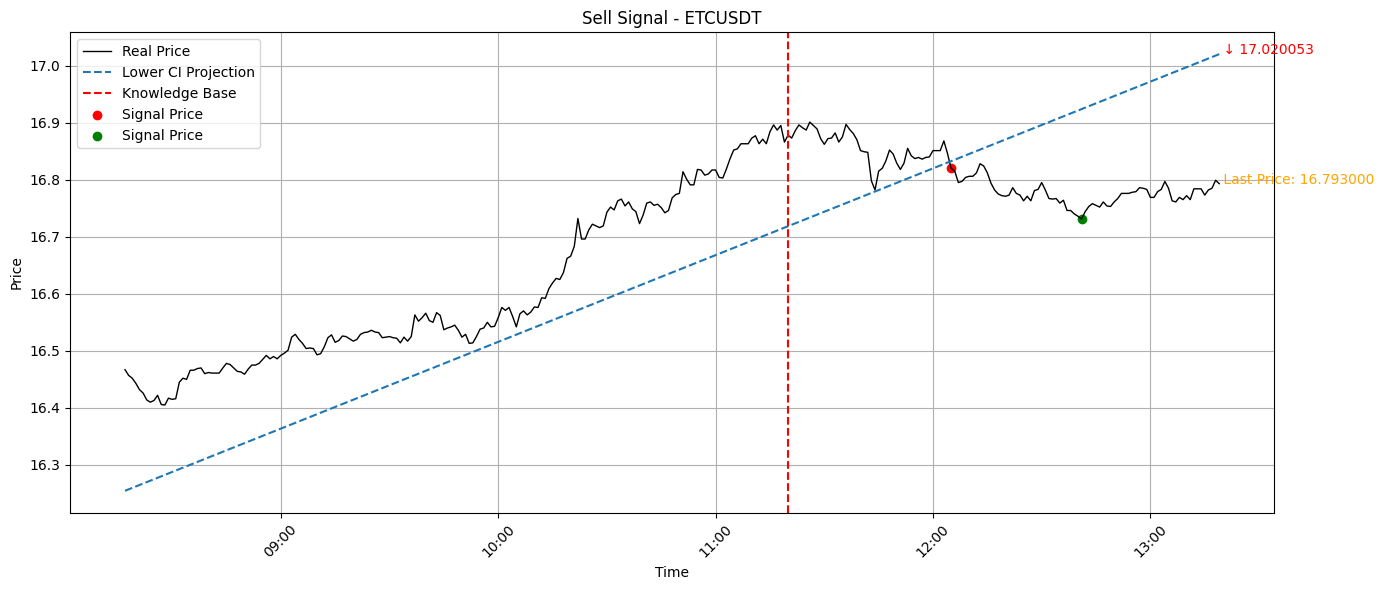

took profit @13.084000   pnl: 0.15


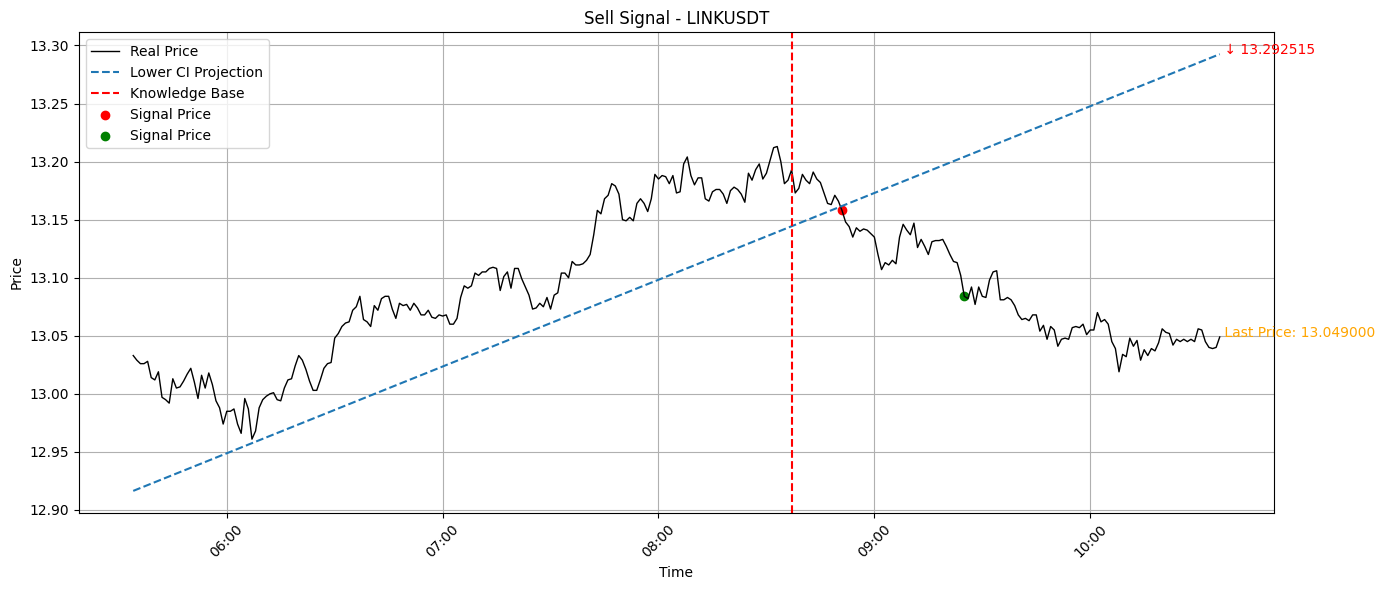

stop loss @12.690000   pnl: 0.1


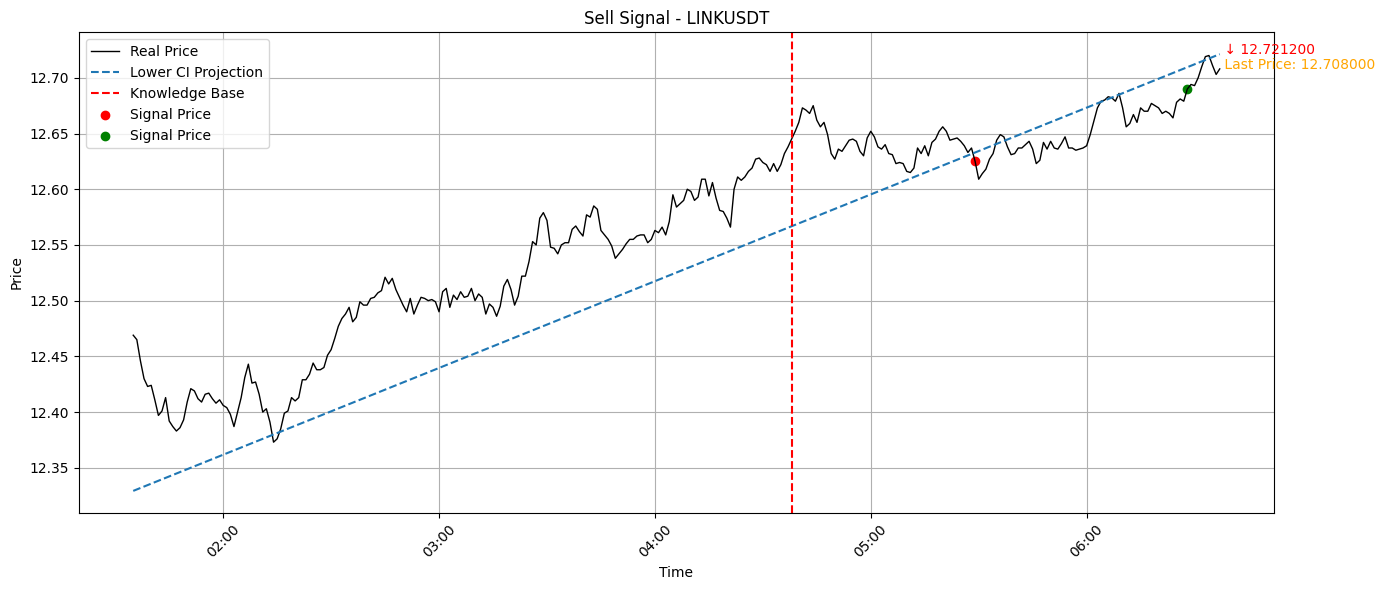

took profit @0.615000   pnl: 0.15


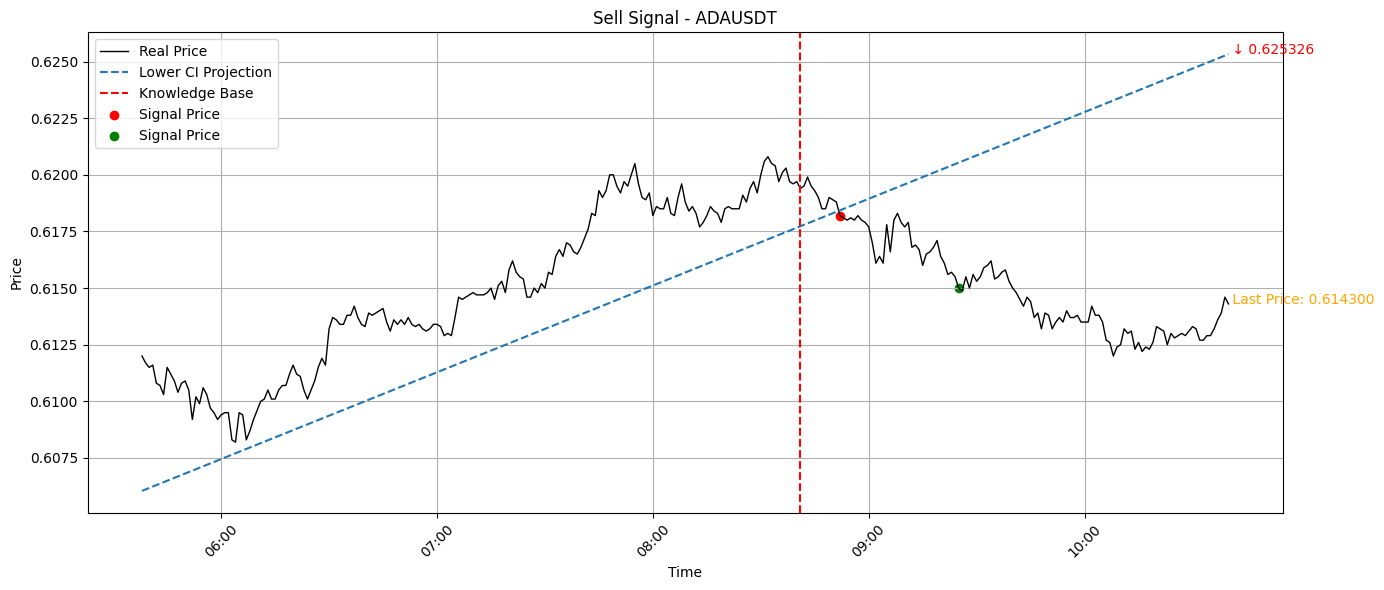

took profit @314.240000   pnl: 0.2


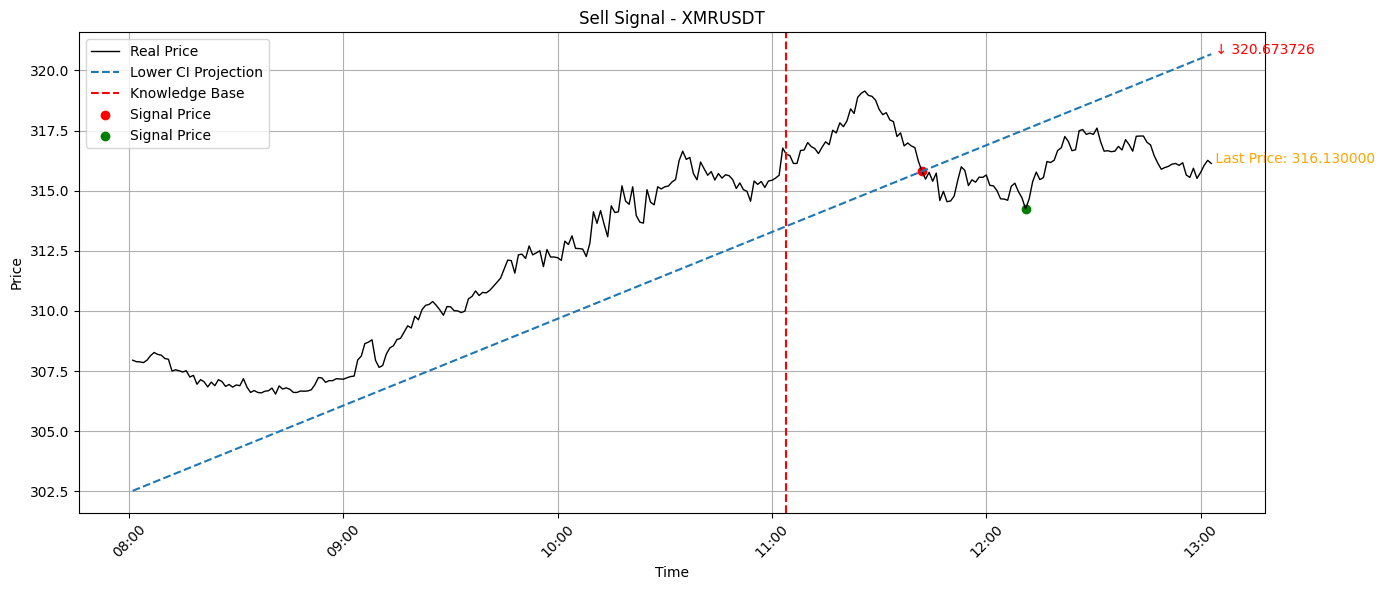

took profit @314.340000   pnl: 0.25


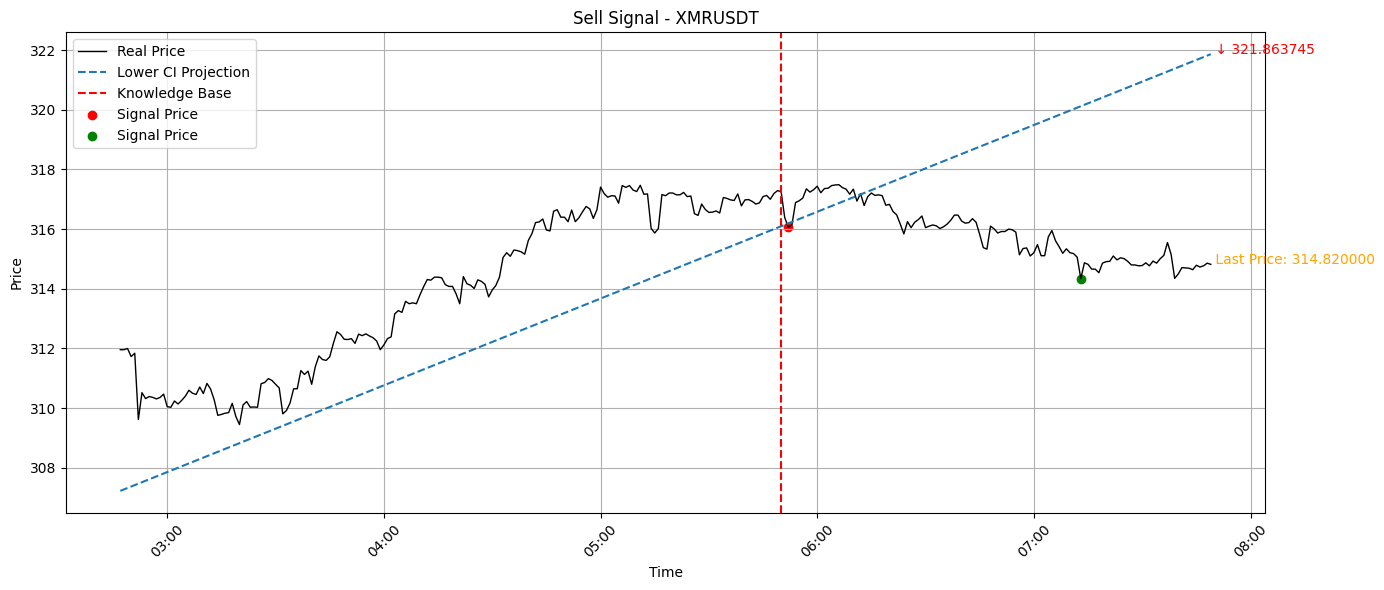

took profit @19.840000   pnl: 0.3


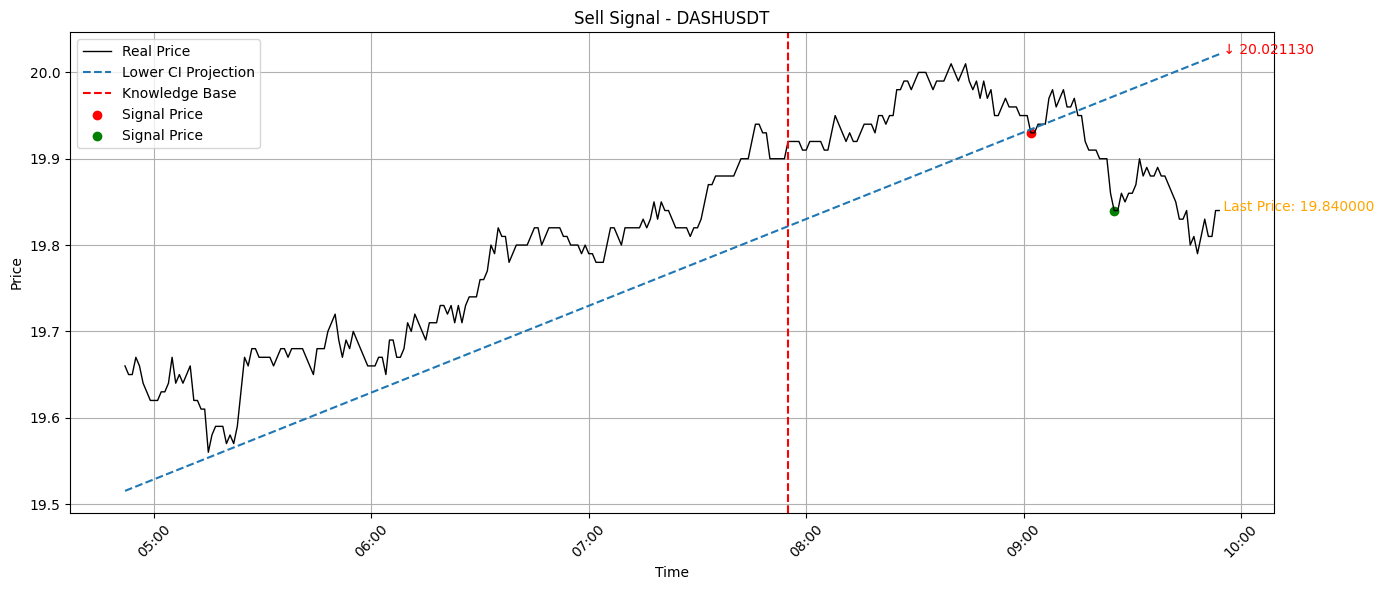

stop loss @19.990000   pnl: 0.25


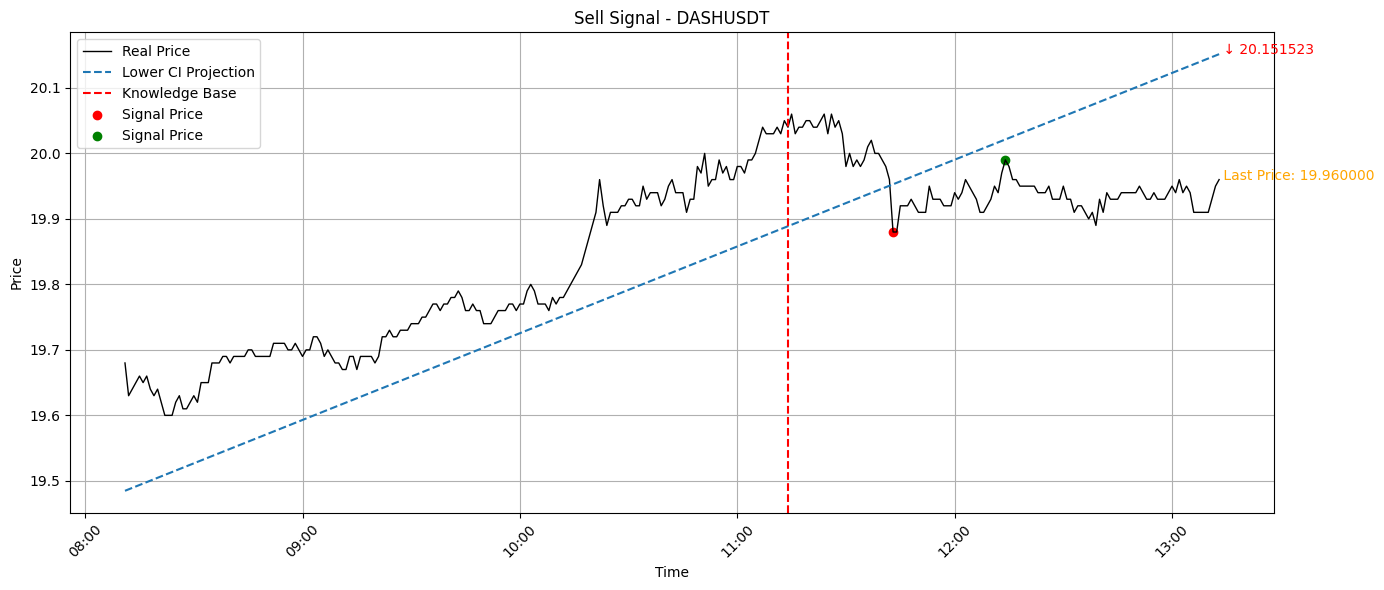

took profit @41.410000   pnl: 0.3


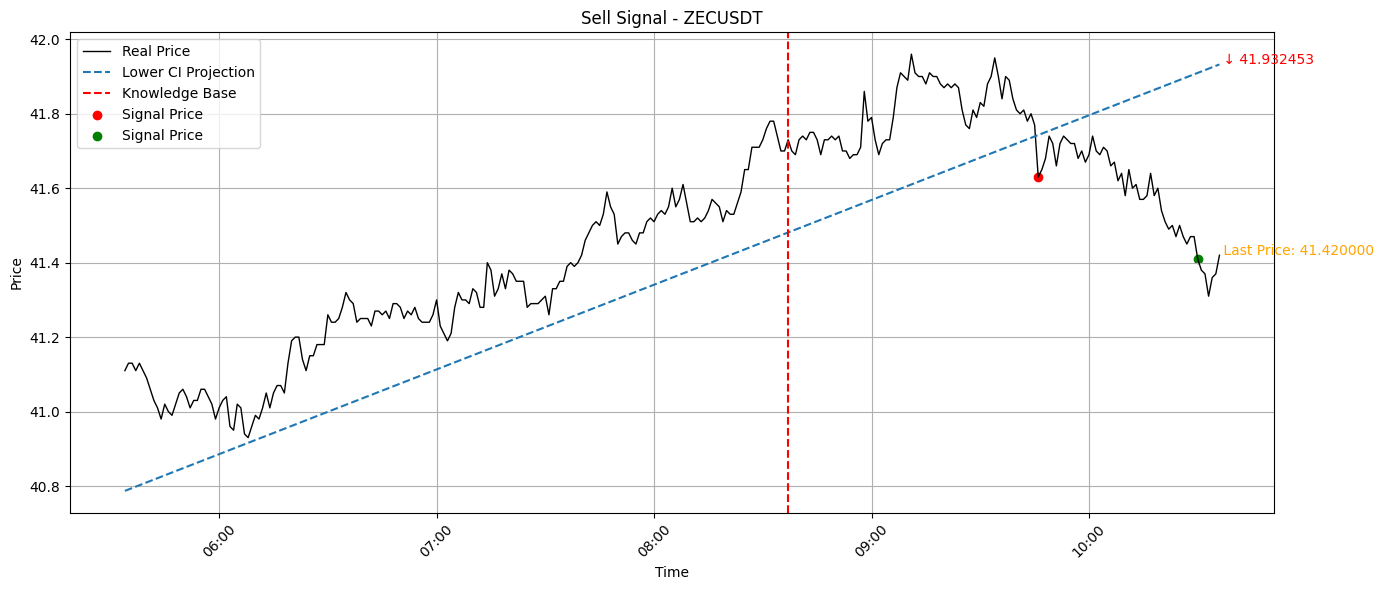

In [ ]:
if __name__ == '__main__':
    global pnl
    data = prepare_data()
    cooldown_bars = 10

    last_signal = { sym: None for sym in data.keys() }

    for sym, df_full in data.items():
        n = len(df_full)
        for i in range(n - WIDE_SIZE + 1):
            last = last_signal[sym]
            if last is not None and i < last + cooldown_bars:
                continue

            window      = df_full.iloc[i : i+WINDOW_SIZE]
            test_window = df_full.iloc[i : i+WIDE_SIZE]

            if window['close'].nunique() <= 1:
                continue

            model = create_model(window)
            if model.rsquared <= 0.90:
                continue

            preds = get_predictions(window, model, alpha=0.01)
            lower_proj = get_lower_series(preds['obs_ci_lower'])

            if get_slope(window,preds)<0:
                continue
            
            signal_found = False
            for k in range(WINDOW_SIZE-1, WIDE_SIZE-1):
                prev_thr  = lower_proj.iloc[k]
                curr_p    = test_window['close'].iloc[k]
                next_p    = test_window['close'].iloc[k+1]
                next_thr  = lower_proj.iloc[k+1]

                if curr_p > prev_thr and next_p < next_thr:
                    sell_rel     = k+1
                    sell_bar     = i + sell_rel
                    sell_time    = df_full['open_time'].iloc[sell_bar]
                    sell_price   = df_full['close'].iloc[sell_bar]

                    for t in range(k, WIDE_SIZE-1):
                        next_low  = test_window['low'].iloc[t+1]
                        next_high = test_window['high'].iloc[t+1]

                        if next_low < sell_price * 0.995:
                            buy_rel   = t+1
                            buy_bar   = i + buy_rel
                            buy_time  = df_full['open_time'].iloc[buy_bar]
                            buy_price = df_full['close'].iloc[buy_bar]
                            pnl += 0.05
                            print(f'took profit @{buy_price:.6f}   pnl: {round(pnl,2)}')
                            draw(test_window, lower_proj, sym,sell_time, sell_price,buy_time, buy_price)
                            break

                        elif next_high > sell_price * 1.005:
                            buy_rel   = t+1
                            buy_bar   = i + buy_rel
                            buy_time  = df_full['open_time'].iloc[buy_bar]
                            buy_price = df_full['close'].iloc[buy_bar]
                            pnl -= 0.05
                            print(f'stop loss @{buy_price:.6f}   pnl: {round(pnl,2)}')
                            draw(test_window, lower_proj, sym,sell_time, sell_price,buy_time, buy_price)
                            break

                    last_signal[sym] = sell_bar
                    signal_found     = True
                    break   

            if signal_found:
                continue